In [ ]:
import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# --- 0. Configurare Hardware T4 ---
# Pe Colab T4, WandB poate fi enervant, îl oprim.
os.environ["WANDB_DISABLED"] = "true"

print(f"Folosesc GPU: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Placa video: {torch.cuda.get_device_name(0)}")
    # T4 are ~15GB VRAM, deci ne putem lăfăi.

# 1. Model & Tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 2. Încărcare Date (Full Dataset)
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

# --- Mapare Ekman (28 -> 7 Clase) ---
def map_to_ekman(example):
    original_label = example['label']
    # 0: Anger, 1: Disgust, 2: Fear, 3: Joy, 4: Sadness, 5: Surprise, 6: Neutral
    mapping = {
        2: 0, 3: 0, 10: 0,              # Anger group
        11: 1,                          # Disgust
        14: 2, 19: 2,                   # Fear group
        0: 3, 1: 3, 4: 3, 5: 3, 8: 3, 13: 3, 15: 3, 17: 3, 18: 3, 20: 3, 21: 3, 23: 3, # Joy group
        9: 4, 12: 4, 16: 4, 24: 4, 25: 4, # Sadness group
        6: 5, 7: 5, 22: 5, 26: 5,       # Surprise group
        27: 6                           # Neutral
    }
    return {'label': mapping.get(original_label, 6)}

print(" Aplic maparea Ekman pe tot setul de date...")
dataset = dataset.map(map_to_ekman)

# --- Tokenizare ---
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

print(f"✅ Gata! Antrenăm pe TOT setul: {len(train_dataset)} exemple.")

# 3. Model
NUM_LABELS = 7
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=NUM_LABELS)

# 4. Metrici (Cruciale pentru imbalans)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# 5. Setări Optimizate pentru T4 (High VRAM)
training_args = TrainingArguments(
    output_dir="./results_colab_t4",

    # Strategie
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,

    # Hyperparametrii
    learning_rate=2e-5,
    num_train_epochs=5,
    warmup_ratio=0.1,
    weight_decay=0.01,

    # --- T4 POWER SETTINGS ---
    per_device_train_batch_size=32,  # 32 intră lejer pe T4 cu DistilBERT
    per_device_eval_batch_size=64,   # Evaluarea e mai ușoară, punem dublu
    gradient_accumulation_steps=1,   # Nu mai e nevoie să simulăm batch-uri
    fp16=True,                       # Viteză maximă

    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

print("Train")
trainer.train()

# Salvare finală
trainer.save_model("./model_final_t4")
print("🏁 Antrenare completă.")

Folosesc GPU: True
Placa video: Tesla T4


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

🔄 Aplic maparea Ekman pe tot setul de date...


Map:   0%|          | 0/168980 [00:00<?, ? examples/s]

Map:   0%|          | 0/42245 [00:00<?, ? examples/s]

Map:   0%|          | 0/168980 [00:00<?, ? examples/s]

Map:   0%|          | 0/42245 [00:00<?, ? examples/s]

✅ Gata! Antrenăm pe TOT setul: 168980 exemple.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Pornim motoarele T4...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.115300,1.132882,0.545153,0.339641,0.557644,0.317374
2,1.070900,1.121368,0.547923,0.391450,0.455133,0.361250
3,1.077600,1.140685,0.543970,0.388173,0.447121,0.361713
4,0.964900,1.172372,0.540561,0.388474,0.418650,0.370532
5,0.919900,1.210663,0.533649,0.384328,0.408094,0.369161


🏁 Antrenare completă.


Generez predicțiile pentru matricea de confuzie...


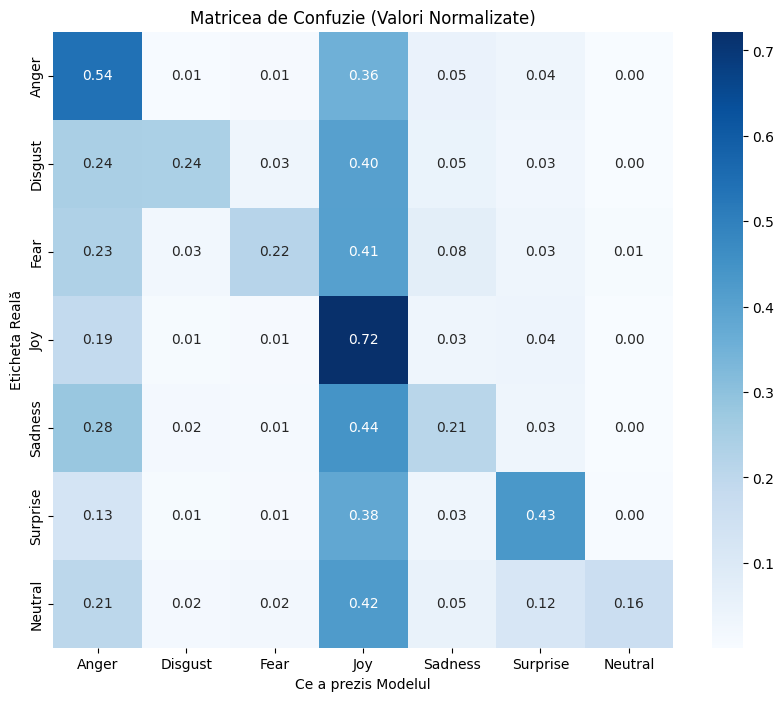

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Obținem predicțiile pe tot setul de test
print("Generez predicțiile pentru matricea de confuzie...")
predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# 2. Definim numele claselor (Ekman mapping)
# Ordinea trebuie să fie exactă: 0..6
class_names = ["Anger", "Disgust", "Fear", "Joy", "Sadness", "Surprise", "Neutral"]

# 3. Calculăm matricea
cm = confusion_matrix(labels, preds)

# 4. O normalizăm (opțional, dar recomandat)
# Asta ne arată procentaje (ex: 60% din Anger a fost ghicit corect), nu doar numere brute
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 5. Desenăm cu Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.ylabel('Eticheta Reală')
plt.xlabel('Ce a prezis Modelul')
plt.title('Matricea de Confuzie (Valori Normalizate)')
plt.show()